In [1]:
# run these cells to generate clean data 
# Data from John Hopkins and World Bank
# https://github.com/CSSEGISandData/COVID-19
using CSV, Plots, DataFrames, Dates

In [2]:
wb_pop = CSV.read("covid_data/wb_population.csv")
dfp = wb_pop[:,Symbol.(["Country Name", "2018"])]
rename!(dfp,Symbol.(["country"; "population"]))
size(dfp)

(264, 2)

In [3]:
confirmed_global = CSV.read("covid_data/time_series_covid19_confirmed_global.csv")
df = confirmed_global[ismissing.(confirmed_global[!,Symbol("Province/State")]),2:end]
first_date = Date(string(names(df)[4]),dateformat"m/d/y")
last_date = Date(string(names(df)[length(names(df))]),dateformat"m/d/y")
println(first_date, "......", last_date)
# rename daily case count columns
rename!(df,Symbol.(["country"; "lat"; "long"; ["D$(i-3)" for i in 4:size(df)[2]]]))
size(df)

0020-01-22......0020-04-08


(181, 81)

In [4]:
# combine case counts with population data using :country as key
dfc = join(df, dfp, kind = :inner, on = intersect(names(df), names(dfp)))
dfc = hcat(dfc[:,[:country; :population; :lat; :long]], 
        DataFrame(first=[first_date for i in 1:size(dfc)[1]],
                  last=[last_date for i in 1:size(dfc)[1]]),
        dfc[:,Symbol.(["D$i" for i in 1:size(dfc)[2]-4])])
size(dfc)

(156, 84)

In [5]:
# function to compute slope of best fit to data on integer grid
function slope(data)
    np = length(data)
    x_bar = sum(1:np)/np
    y_bar = sum(data)/np
    sl = sum( ((1:np) .- x_bar).*(data .- y_bar)) / sum( ((1:np) .- x_bar).^2 )
end

slope (generic function with 1 method)

In [7]:
# fuction to get best intervention date by taking difference of before and after
# slopes fitted to log of data. data is stripped of leading zero counts before
# search for best intervention and then number of stripped zeros are added back
function best_ld(data)
    striped = data[data[:,1] .!= 0,:]
    np = length(striped)
    slopes = [ slope(log.(striped[1:k]))-slope(log.(striped[k+1:end])) for k in 2:np-2] 
    if length(slopes) > 0
        sp = findmax(slopes)[2]+1
    else
        sp = 0
    end
    size(data)[1] - (length(striped)-sp)
end

best_ld (generic function with 1 method)

In [8]:
best_ld(Array(dfc[120,7:end]))

73

In [9]:
# compute best intervention dates for all data
blds = [ best_ld(Array(dfc[i,7:end])) for i in 1:size(dfc)[1] ]
println(blds)

[76, 49, 45, 67, 60, 76, 47, 74, 64, 73, 35, 61, 58, 44, 76, 57, 75, 53, 71, 62, 54, 50, 60, 72, 74, 60, 76, 44, 55, 48, 67, 36, 68, 50, 52, 66, 70, 71, 60, 58, 73, 56, 67, 56, 63, 75, 4, 62, 51, 7, 54, 37, 56, 74, 56, 63, 75, 48, 43, 13, 54, 36, 45, 76, 64, 52, 11, 65, 56, 54, 35, 60, 45, 57, 62, 73, 64, 63, 5, 50, 56, 70, 59, 39, 49, 75, 60, 59, 75, 74, 76, 39, 76, 60, 75, 72, 76, 39, 36, 76, 50, 76, 51, 47, 76, 45, 45, 40, 38, 55, 43, 45, 42, 52, 56, 3, 45, 72, 65, 73, 76, 76, 63, 72, 37, 58, 3, 65, 61, 76, 61, 62, 73, 76, 74, 57, 55, 18, 68, 60, 62, 66, 64, 62, 64, 69, 46, 76, 66, 66, 70, 72, 71, 76, 76, 75]


In [78]:
length(blds)

156

In [79]:
[ 0.5 for i in 1:length(blds) ]

156-element Array{Float64,1}:
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 ⋮  
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5
 0.5

In [10]:
# make new dataframe by adding columns for best intervention default
# betas (before and after intervention).
dfca = hcat(dfc[:,[:country; :population; :lat; :long; :first; :last]], 
        DataFrame(intervention=blds),
        DataFrame(beta_before=[ 0.5 for i in 1:length(blds) ]),
        DataFrame(beta_after=[ 0.05 for i in 1:length(blds) ]),
        dfc[:,Symbol.(["D$i" for i in 1:size(dfc)[2]-6])])

,country,population,lat,long,first,last
,String,Int64⍰,Float64,Float64,Date,Date
1,Afghanistan,37172386,33.0,65.0,0020-01-22,0020-04-08
2,Albania,2866376,41.1533,20.1683,0020-01-22,0020-04-08
3,Algeria,42228429,28.0339,1.6596,0020-01-22,0020-04-08
4,Andorra,77006,42.5063,1.5218,0020-01-22,0020-04-08
5,Angola,30809762,-11.2027,17.8739,0020-01-22,0020-04-08
6,Antigua and Barbuda,96286,17.0608,-61.7964,0020-01-22,0020-04-08
7,Argentina,44494502,-38.4161,-63.6167,0020-01-22,0020-04-08
8,Armenia,2951776,40.0691,45.0382,0020-01-22,0020-04-08
9,Austria,8847037,47.5162,14.5501,0020-01-22,0020-04-08


In [11]:
names(dfca)

87-element Array{Symbol,1}:
 :country     
 :population  
 :lat         
 :long        
 :first       
 :last        
 :intervention
 :beta_before 
 :beta_after  
 :D1          
 :D2          
 :D3          
 :D4          
 ⋮            
 :D67         
 :D68         
 :D69         
 :D70         
 :D71         
 :D72         
 :D73         
 :D74         
 :D75         
 :D76         
 :D77         
 :D78         

In [16]:
# rename!(df, Dict(:0 => :country))
CSV.write("../SIRjs/data_jhp_clean.csv",dfca)

"../SIRjs/data_jhp_clean.csv"

In [17]:
all = CSV.read("../SIRjs/data_jhp_clean.csv")
country = "South Africa"

"South Africa"

In [18]:
N = all[(all[!,Symbol("country")].==country),:population][1]

57779622

In [19]:
lock_down = all[(all[!,Symbol("country")].==country),:intervention][1]

65

65
[1; 1; 1; 3; 3; 7; 13; 17; 24; 38; 51; 62; 62; 116; 150; 202; 240; 274; 402; 554; 709; 927; 1170; 1187; 1280; 1326; 1353; 1380; 1462; 1505; 1585; 1655; 1686; 1749; 1845]
23


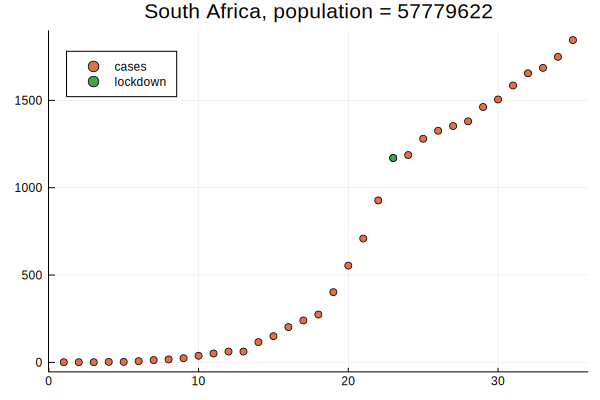

In [20]:
# load clean data and get cases for one country
all = CSV.read("../SIRjs/data_jhp_clean.csv")
country = "South Africa"
N = all[(all[!,Symbol("country")].==country),:population][1]
ld = all[(all[!,Symbol("country")].==country),:intervention][1]
println(ld)
data = convert(Array,
    all[(all[!,Symbol("country")].==country),
        10:size(all)[2]])[1,:]
save_data = data
data = data[data[:,1] .!= 0,:]
println(data)
ld = ld - (length(save_data)-length(data)) + 1
println(ld)
data_labels="cases"
data_colors=2
plot_title="$country, population = $N"
scatter(data, legend=:topleft, label=data_labels,
            color=data_colors,title=plot_title)
scatter!([ld],[data[ld]],color=3,label="lockdown")

In [21]:
function simulate(μ,n,β,γ,N)
    sim = reshape(ones(n*4),(n,4))
    sim[1,:]= μ   # [(N-1)/N, 1/N, 0, 1/N]
    for k in 2:n
        s, i, r, c = sim[k-1,:]
        ns = s - β[k-1]*s*i
        ni = i + β[k-1]*s*i - γ[k-1]*i
        nr = r + γ[k-1]*i
        nc = c + β[k-1]*s*i
        sim[k,:] = [ns, ni, nr, nc]
    end
    sim
end

simulate (generic function with 1 method)

In [26]:
function expand_params(params,bps,n)
    p = params[end] * ones(n)
    for k in (length(bps)-1):-1:1
        p[1:bps[k]-1]=params[k]*ones(bps[k]-1)
    end
    p
end

expand_params (generic function with 1 method)

In [27]:
using Optim

In [32]:
n=size(data)[1]
μ = [(N-1)/N, 1/N, 0, 1/N]
initial_betas = [0.3 0.15]
initial_gammas = [0.1 0.1]
breaks = [ld n]
loss = function(betas)
    β = expand_params(betas,breaks,n)
    γ = expand_params(initial_gammas,breaks,n)
    sim = N*simulate(μ,n,β,γ,N)[:,4]
    sum( (sim .- data[:,1]).^2 ) 
end

#27 (generic function with 1 method)

In [33]:
loss(initial_betas)

2.5192978545920704e7

In [34]:
res = optimize(loss,initial_betas)

 * Status: success

 * Candidate solution
    Minimizer: [4.63e-01, 6.65e-02]
    Minimum:   5.804559e+04

 * Found with
    Algorithm:     Nelder-Mead
    Initial Point: [3.00e-01, 1.50e-01]

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    62
    f(x) calls:    123


In [35]:
opt_betas = Optim.minimizer(res) 

1×2 Array{Float64,2}:
 0.46322  0.0665423

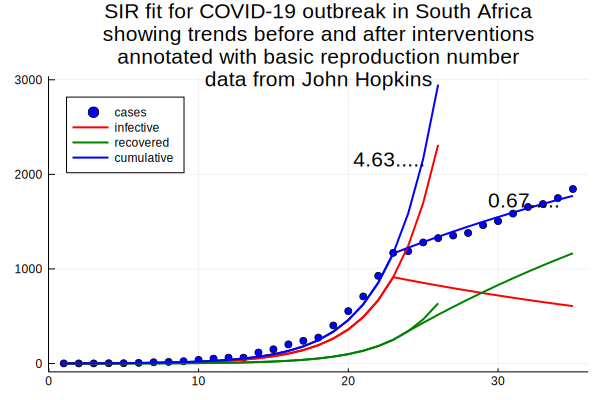

In [36]:
n=size(data)[1]
μ = [(N-1)/N, 1/N, 0, 1/N]
gammas = [0.1 0.1]
bps = [ld n]
γ = expand_params(gammas,bps,n)
β_opt = opt_betas # [0.463 0.058]
labels="cases"
colors=:blue
ptl1 = "SIR fit for COVID-19 outbreak in $country"
ptl2 = " showing trends before and after interventions "
ptl3 = " annotated with basic reproduction number "
ptl4 = "data from John Hopkins"
plot_title= ptl1 * "\n" * ptl2 * "\n" * ptl3 * "\n" * ptl4
fig = scatter(data,legend=:topleft,color=colors,label=labels,title=plot_title)
labels = [ "infective" "recovered" "cumulative"]
colors = [:red :green :blue]
β=expand_params([β_opt[1]],[bps[1]],n)
r=round(β[1]/γ[1],digits=2)
sim = simulate(μ,n,β,γ,N)
y = N.*sim[1:bps[1]+3,2:4]
plot!(y,color=colors,label=labels,linewidth=2,
    annotations = (size(y)[1]-1, y[size(y)[1]-1,3], Plots.text("$r"*".....", :right)))
for k in 2:length(bps)
    β = expand_params([β_opt[j] for j in 1:k],[bps[j] for j in 1:k],n)
    # β[ld[k-1]+1:end]=ldb[k]*ones(n-ld[k-1])
    r=round(β[bps[k]]/γ[bps[k]],digits=2)
    sim = simulate(μ,n,β,γ,N)
    m = min(bps[k]+3,n)
    y = N.*sim[1:m,2:4]
    plot!(y,color=colors,label=nothing,linewidth=2,
       annotations = (bps[k]-1, y[bps[k]-1,3], Plots.text("$r"*".....", :right)))
end
savefig(fig,"covid_plots/SIRfit$country")
fig

In [56]:
all = CSV.read("../SIRjs/data_jhp_clean.csv", copycols=true)
for row in 1:size(all)[1]
    country = all[row,:country]
    N = all[(all[!,Symbol("country")].==country),:population][1]
    if ismissing(N)
        N=100000
    end
    ld = all[(all[!,Symbol("country")].==country),:intervention][1]
    data = convert(Array,all[(all[!,Symbol("country")].==country),
        10:size(all)[2]])[1,:]
    save_data = data
    data = data[data[:,1] .!= 0,:]
    ld = ld - (length(save_data)-length(data)) + 1
     # optimise
    n=size(data)[1]
    μ = [(N-1)/N, 1/N, 0, 1/N]
    initial_betas = [0.3 0.15]
    initial_gammas = [0.1 0.1]
    breaks = [ld n]
    loss = function(betas)
        β = expand_params(betas,breaks,n)
        γ = expand_params(initial_gammas,breaks,n)
        sim = N*simulate(μ,n,β,γ,N)[:,4]
        sum( (sim .- data[:,1]).^2 ) 
    end
    res = optimize(loss,initial_betas)
    opt_betas = Optim.minimizer(res) 
    all[row,:beta_before] = round(opt_betas[1],digits=2)
    all[row,:beta_after] = round(opt_betas[2],digits=2)
    println(country, " -> ", ld, "->", all[row,:beta_before], "->", all[row,:beta_after])
end

Afghanistan -> 44->0.24->0.01
Albania -> 3->4.45->0.17
Algeria -> 12->0.43->0.22
Andorra -> 28->0.33->0.09
Angola -> 3->0.38->0.22
Antigua and Barbuda -> 26->0.19->0.17
Argentina -> 7->1.03->0.2
Armenia -> 36->0.31->-0.12
Austria -> 31->0.44->0.08
Azerbaijan -> 35->0.29->0.16
Bahrain -> 3->5.4->0.15
Bangladesh -> 16->0.26->0.27
Barbados -> 4->1.21->0.17
Belarus -> 8->0.03->0.34
Belgium -> 64->0.27->-0.24
Benin -> 4->0.23->0.23
Bhutan -> 32->0.1->0.25
Bolivia -> 5->0.88->0.21
Bosnia and Herzegovina -> 29->0.34->0.08
Brazil -> 28->0.42->0.22
Bulgaria -> 9->0.84->0.15
Burkina Faso -> 3->4.25->0.18
Cabo Verde -> 3->0.84->0.09
Cambodia -> 68->0.16->-0.05
Cameroon -> 31->0.33->0.05
Central African Republic -> 8->0.12->0.18
Chad -> 20->0.2->-0.19
Chile -> 4->3.51->0.22
Colombia -> 12->0.64->0.21
Costa Rica -> 5->1.56->0.17
Cote d'Ivoire -> 19->0.4->0.16
Croatia -> 3->3.33->0.2
Cuba -> 19->0.41->0.17
Cyprus -> 4->2.02->0.19
Denmark -> 17->0.57->0.17
Djibouti -> 11->0.35->0.32
Dominican Republi

In [57]:
CSV.write("../SIRjs/data_jhp_clean.csv", all)

"../SIRjs/data_jhp_clean.csv"